In [1]:
from tqdm import tqdm

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## Loading the dataset

In [2]:
dataset = datasets.MNIST(
    root='..\\..\\datasets',
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Define a simple U-Net model to predict the noise at each step

In [3]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.bottleneck = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.dec3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.time_emb = nn.Linear(1, 256)

    def forward(self, x, t):
        t_emb = torch.sin(self.time_emb(t.unsqueeze(-1).float()))
        t_emb = t_emb.view(t_emb.size(0), -1, 1, 1)

        e1 = F.relu(self.enc1(x))
        e2 = F.relu(self.enc2(F.avg_pool2d(e1, 2)))
        e3 = F.relu(self.enc3(F.avg_pool2d(e2, 2)))
        
        b = F.relu(self.bottleneck(e3) + t_emb)
    
        d3 = F.interpolate(b, scale_factor=2, mode='nearest')
        d3 = F.relu(self.dec3(d3 + F.interpolate(e3, scale_factor=2, mode='nearest')))
        
        d2 = F.interpolate(d3, scale_factor=2, mode='nearest')
        d2 = F.relu(self.dec2(d2 + F.interpolate(e2, scale_factor=2, mode='nearest')))
        
        d1 = self.dec1(d2 + e1)
        
        return d1

### Training the model on MNIST with 60 epochs

In [ ]:
epochs = 60
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
T = 1000

model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alpha_hat = torch.cumprod(alphas, dim=0)

# Adding noise to image at step t
def add_noise(x_0, t):
    noise = torch.randn_like(x_0).to(device)
    sqrt_alpha_hat = alpha_hat[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t]).view(-1, 1, 1, 1)
    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise
    return x_t, noise


model.train()
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for x_0, _ in dataloader:
        x_0: Tensor = x_0.to(device)
        
        t = torch.randint(0, T, (x_0.size(0),), device=device)
        
        x_t, noise = add_noise(x_0, t)
        
        pred_noise = model(x_t, t)
        
        loss: Tensor = criterion(pred_noise, noise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}")

  2%|▏         | 1/60 [00:27<26:44, 27.19s/it]

Epoch [1/60], Loss: 0.2529367311422759


  3%|▎         | 2/60 [00:48<22:55, 23.71s/it]

Epoch [2/60], Loss: 0.10233399755696752


  5%|▌         | 3/60 [01:11<22:04, 23.24s/it]

Epoch [3/60], Loss: 0.08559532174423559


  7%|▋         | 4/60 [01:37<22:52, 24.51s/it]

Epoch [4/60], Loss: 0.0760981584869341


  8%|▊         | 5/60 [02:02<22:34, 24.63s/it]

Epoch [5/60], Loss: 0.06810935922681904


 10%|█         | 6/60 [02:26<22:06, 24.57s/it]

Epoch [6/60], Loss: 0.06464011481861824


 12%|█▏        | 7/60 [02:50<21:31, 24.37s/it]

Epoch [7/60], Loss: 0.05857232718198284


 13%|█▎        | 8/60 [03:14<20:59, 24.22s/it]

Epoch [8/60], Loss: 0.05429284328987985


 15%|█▌        | 9/60 [03:38<20:27, 24.07s/it]

Epoch [9/60], Loss: 0.05278622173170037


 17%|█▋        | 10/60 [04:02<20:00, 24.01s/it]

Epoch [10/60], Loss: 0.05030182152907096


 18%|█▊        | 11/60 [04:26<19:31, 23.91s/it]

Epoch [11/60], Loss: 0.048367871360769914


 20%|██        | 12/60 [04:49<19:00, 23.76s/it]

Epoch [12/60], Loss: 0.04619966284123692


 22%|██▏       | 13/60 [05:12<18:30, 23.62s/it]

Epoch [13/60], Loss: 0.044143834991305114


 23%|██▎       | 14/60 [05:37<18:18, 23.87s/it]

Epoch [14/60], Loss: 0.0430014659322973


 25%|██▌       | 15/60 [06:00<17:44, 23.64s/it]

Epoch [15/60], Loss: 0.041243226309098414


 27%|██▋       | 16/60 [06:24<17:29, 23.84s/it]

Epoch [16/60], Loss: 0.04048286157964008


 28%|██▊       | 17/60 [06:48<17:01, 23.75s/it]

Epoch [17/60], Loss: 0.03882753688182785


 30%|███       | 18/60 [07:12<16:46, 23.96s/it]

Epoch [18/60], Loss: 0.039237403948265095


 32%|███▏      | 19/60 [07:36<16:20, 23.91s/it]

Epoch [19/60], Loss: 0.037969930792477596


 33%|███▎      | 20/60 [08:01<16:05, 24.14s/it]

Epoch [20/60], Loss: 0.03682149279076281


 35%|███▌      | 21/60 [08:24<15:30, 23.86s/it]

Epoch [21/60], Loss: 0.035673763551342205


 37%|███▋      | 22/60 [08:49<15:16, 24.13s/it]

Epoch [22/60], Loss: 0.035682988366973936


 38%|███▊      | 23/60 [09:13<14:56, 24.22s/it]

Epoch [23/60], Loss: 0.034570564331212784


 40%|████      | 24/60 [09:37<14:32, 24.25s/it]

Epoch [24/60], Loss: 0.03410199657082558


 42%|████▏     | 25/60 [10:00<13:52, 23.78s/it]

Epoch [25/60], Loss: 0.033649729552871384


 43%|████▎     | 26/60 [10:23<13:17, 23.46s/it]

Epoch [26/60], Loss: 0.03380494701789259


 45%|████▌     | 27/60 [10:46<12:56, 23.53s/it]

Epoch [27/60], Loss: 0.033225199152062186


 47%|████▋     | 28/60 [11:10<12:33, 23.53s/it]

Epoch [28/60], Loss: 0.032559299515858134


 48%|████▊     | 29/60 [11:36<12:30, 24.20s/it]

Epoch [29/60], Loss: 0.032413858670129705


 50%|█████     | 30/60 [11:59<12:01, 24.06s/it]

Epoch [30/60], Loss: 0.03200630629574185


 52%|█████▏    | 31/60 [12:22<11:27, 23.71s/it]

Epoch [31/60], Loss: 0.03182386896058695


 53%|█████▎    | 32/60 [12:45<10:57, 23.48s/it]

Epoch [32/60], Loss: 0.03136015111910127


 55%|█████▌    | 33/60 [13:10<10:43, 23.83s/it]

Epoch [33/60], Loss: 0.030490243251421557


 57%|█████▋    | 34/60 [13:35<10:30, 24.24s/it]

Epoch [34/60], Loss: 0.030598596135563434


 58%|█████▊    | 35/60 [13:59<10:04, 24.18s/it]

Epoch [35/60], Loss: 0.030234556903304066


 60%|██████    | 36/60 [14:24<09:43, 24.32s/it]

Epoch [36/60], Loss: 0.02958901726138363


 62%|██████▏   | 37/60 [14:48<09:19, 24.31s/it]

Epoch [37/60], Loss: 0.029803812563387568


 63%|██████▎   | 38/60 [15:12<08:53, 24.24s/it]

Epoch [38/60], Loss: 0.029454406001356872


 65%|██████▌   | 39/60 [15:36<08:29, 24.27s/it]

Epoch [39/60], Loss: 0.02908681978437819


 67%|██████▋   | 40/60 [16:00<08:01, 24.07s/it]

Epoch [40/60], Loss: 0.029012211926106705


 68%|██████▊   | 41/60 [16:24<07:38, 24.12s/it]

Epoch [41/60], Loss: 0.028568522532039613


 70%|███████   | 42/60 [16:49<07:16, 24.23s/it]

Epoch [42/60], Loss: 0.029132869527506423


 72%|███████▏  | 43/60 [17:13<06:50, 24.13s/it]

Epoch [43/60], Loss: 0.028425842414357895


 73%|███████▎  | 44/60 [17:37<06:27, 24.24s/it]

Epoch [44/60], Loss: 0.028114702685603073


 75%|███████▌  | 45/60 [18:02<06:06, 24.43s/it]

Epoch [45/60], Loss: 0.028328327418390368


 77%|███████▋  | 46/60 [18:26<05:39, 24.27s/it]

Epoch [46/60], Loss: 0.027936234454642227


 78%|███████▊  | 47/60 [18:50<05:15, 24.27s/it]

Epoch [47/60], Loss: 0.02758665573098131


 80%|████████  | 48/60 [19:17<04:59, 24.92s/it]

Epoch [48/60], Loss: 0.027107544819206825


 82%|████████▏ | 49/60 [19:40<04:29, 24.50s/it]

Epoch [49/60], Loss: 0.027956646456043604


 83%|████████▎ | 50/60 [20:04<04:02, 24.27s/it]

Epoch [50/60], Loss: 0.027487427993083815


 85%|████████▌ | 51/60 [20:28<03:36, 24.10s/it]

Epoch [51/60], Loss: 0.02720293720393801


 87%|████████▋ | 52/60 [20:52<03:13, 24.18s/it]

Epoch [52/60], Loss: 0.026983059986409094


 88%|████████▊ | 53/60 [21:16<02:48, 24.05s/it]

Epoch [53/60], Loss: 0.027029164002410004


 90%|█████████ | 54/60 [21:39<02:23, 23.86s/it]

Epoch [54/60], Loss: 0.026409166366624427


 92%|█████████▏| 55/60 [22:04<02:00, 24.01s/it]

Epoch [55/60], Loss: 0.026399470867712233


 93%|█████████▎| 56/60 [22:28<01:36, 24.17s/it]

Epoch [56/60], Loss: 0.026153288446049066


 95%|█████████▌| 57/60 [22:52<01:12, 24.12s/it]

Epoch [57/60], Loss: 0.026157983483424956


 97%|█████████▋| 58/60 [23:17<00:48, 24.34s/it]

Epoch [58/60], Loss: 0.026260071920592393


 98%|█████████▊| 59/60 [23:42<00:24, 24.47s/it]

Epoch [59/60], Loss: 0.025795139165829494


100%|██████████| 60/60 [24:06<00:00, 24.11s/it]

Epoch [60/60], Loss: 0.025975757421476883


## Generating images using this model

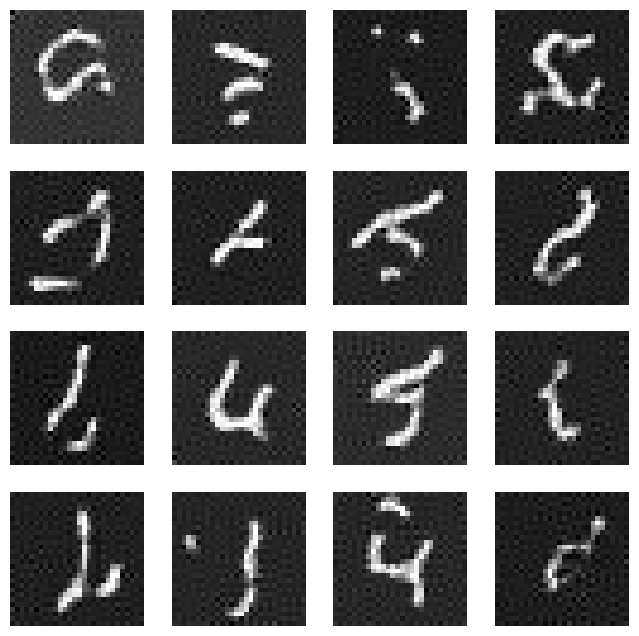

In [ ]:
def generate_images(num_images=16):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn((num_images, 1, 28, 28)).to(device)

        for t in reversed(range(T)):
            t_tensor = torch.full((num_images,), t, device=device)
            pred_noise = model(x_t, t_tensor)
            
            alpha = alphas[t]
            alpha_hat_t = alpha_hat[t]
            beta = betas[t]
            
            if t > 0:
                noise = torch.randn_like(x_t)
            else: # Skip the noise if we want to create x_0 (orginal image)
                noise = torch.zeros_like(x_t)
            
            x_t = (1 / torch.sqrt(alpha)) * (x_t - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * pred_noise) + torch.sqrt(beta) * noise
            
        x_0 = x_t.cpu().clamp(-1, 1)
        x_0 = (x_0 + 1) / 2
        
        fig, axs = plt.subplots(4, 4, figsize=(8, 8))
        axs = axs.flatten()
        for img, ax in zip(x_0, axs):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
        plt.show()

generate_images()

As can be seen the generated images are not very clear, because model architecture is simple and poor training epochs